# Clustering

### Description

- Cluster funds using k-means

In [252]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

## Setup

In [211]:
# Convert to date format
begin_date = '2017-06-01' 
end_date   = '2017-12-31'

## Load Data

In [212]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
# Filter based on date
returns = returns.query('caldt >= @begin_date & caldt <= @end_date')

### Summary
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)
row_info = row_info.query('report_dt >= @begin_date and report_dt <= @end_date')

row_info = row_info.reset_index(drop = True)
row_info = row_info.assign(row = row_info.index)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)
holdings = holdings[row_info['row'].values]

In [213]:
print('Shape of summary information')
print(row_info.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(1845, 8)
Shape of holding information
(1845, 48022)


In [214]:
## Take only one Observation per year and fund and for the spezified timeframe
row_info = row_info.assign(year = row_info['report_dt'].dt.year)

In [215]:
print('Shape of summary information')
print(row_info.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(1845, 9)
Shape of holding information
(1845, 48022)


In [216]:
data.index.astype('category')

CategoricalIndex(['2017-06-30'], categories=[2017-06-30 00:00:00], ordered=False, name='report_dt', dtype='category')

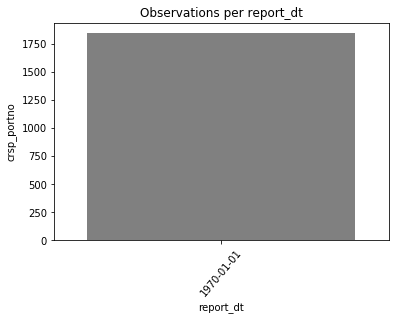

In [217]:
data = row_info.groupby('report_dt').count()
bar_plot = sns.barplot(x = data.index, 
                       y = 'crsp_portno',
                       data = data,
                       color='grey')

# get current axis
ax = plt.gca()

# get current xtick labels
xticks = ax.get_xticks()

# convert all xtick labels to selected format from ms timestamp
ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d') for tm in xticks],
 rotation=50)

bar_plot.set_title('Observations per report_dt')

plt.show()

## Merge Lipper_class onto returns data

In [218]:
returns = returns.merge(row_info[['crsp_fundno','lipper_class']], how='left', on=['crsp_fundno'])
returns = returns.dropna(axis = 0, how = 'any')
returns.shape

(12785, 4)

In [219]:
returns.sample()

,crsp_fundno,caldt,mret,lipper_class
13065,49184,2017-07-31,0.000823,MLCE


## Calc mean return per Obj_cd

### Get unique codes for later

In [220]:
group_by = 'lipper_class'

In [221]:
obj_codes = returns[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values
obj_codes

array(['SCCE', 'LCGE', 'LCVE', 'EIEI', 'SCGE', 'MCVE', 'LCCE', 'MLGE',
       'MCCE', 'SCVE', 'MLVE', 'MCGE', 'MLCE'], dtype=object)

In [222]:
# Analysis of selected funds
returns_obj = returns.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [223]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [224]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [225]:
returns_obj_n = returns_obj.pivot_table(
        values='std', 
        index=['caldt'], 
        columns=group_by)

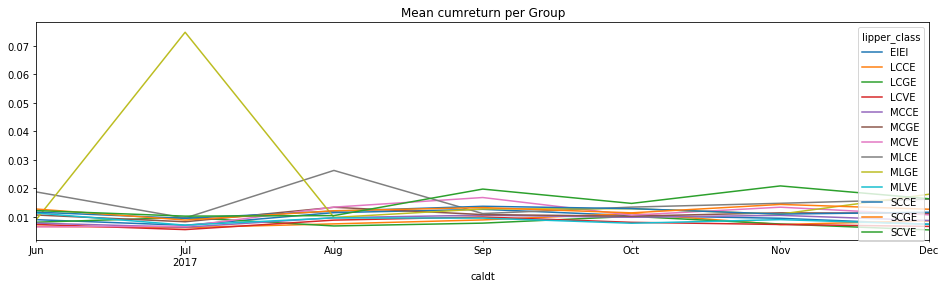

In [226]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,4),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [122]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [123]:
holdings = transformer.transform(holdings)

In [227]:
col_sums = pd.DataFrame(holdings.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings = holdings[:,mask]

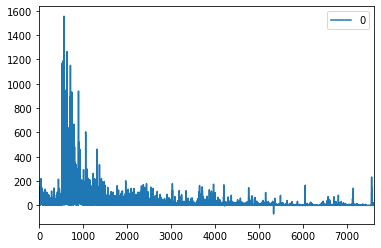

In [228]:
pd.DataFrame(holdings.sum(0)).T.plot()

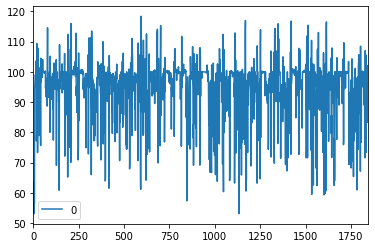

In [229]:
pd.DataFrame(holdings.sum(1)).plot()

In [247]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 6,
                verbose = True,
                n_init = 100, # Number of runs
                n_jobs= -1,
                random_state=123).fit(holdings)

Start kMeans...


In [248]:
labels = pd.DataFrame(kmeans.labels_)

In [249]:
row_info['cluster'] = labels.values

In [250]:
round(pd.crosstab(row_info['cap_class'],row_info['cluster'], margins = True, normalize = 'columns') * 100, 2)

cluster,0,1,2,3,4,5,All
cap_class,,,,,,,
E,5.26,0.00,6.96,6.33,7.43,8.44,7.26
L,34.21,38.46,35.22,29.33,31.69,30.19,31.60
M,28.95,15.38,33.48,36.67,37.13,36.04,36.10
S,31.58,46.15,24.35,27.67,23.74,25.32,25.04


In [251]:
round(pd.crosstab(row_info['style_class'],row_info['cluster'], margins = True, normalize = 'all') * 100, 2)

cluster,0,1,2,3,4,5,All
style_class,,,,,,,
C,0.81,0.27,5.09,6.34,20.38,6.40,39.30
E,0.11,0.00,0.87,1.03,3.85,1.41,7.26
G,0.81,0.22,4.01,5.64,17.67,6.29,34.63
V,0.33,0.22,2.49,3.25,9.92,2.60,18.81
All,2.06,0.70,12.47,16.26,51.82,16.69,100.00


## Chart the returns of the formed clustes

In [242]:
row_info.sample()

,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,cluster
99859,1026163,2017-12-31,"Principal Funds, Inc: LargeCap Growth Fund; Cl...",96.197692,LCGE,LCVE,L,G,24862,0


#### Merge new clusters into returns

In [243]:
returns_merged = returns.merge(row_info, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','crsp_portno','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
49902,2017-11-30,31946.0,1022128.0,0.035377,MLGE,0.0


#### Calc mean return per Obj_cd

In [244]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([0., 1., 3., 2.])

In [245]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [246]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

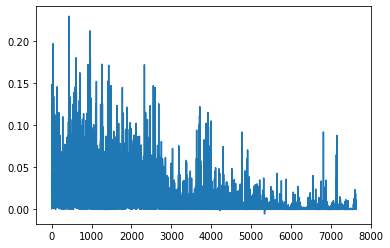

In [236]:
plt.plot(kmeans.cluster_centers_[0,:])

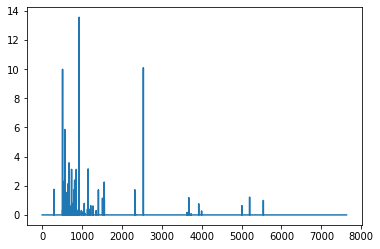

In [237]:
plt.plot(kmeans.cluster_centers_[1,:])

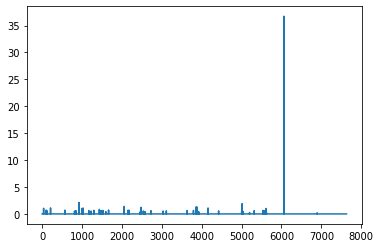

In [244]:
plt.plot(kmeans.cluster_centers_[8,:])

## PCA

In [298]:
pca = TruncatedSVD(n_components=100)
pca = pca.fit(holdings)  

In [299]:
holdings_pca = pca.components_.T

In [300]:
print(np.sum(pca.explained_variance_ratio_))

0.6349667072983886


In [301]:
df = pd.DataFrame(pca.components_).T
df = pd.DataFrame({
    'pca_1' : df.iloc[:,0],
    'pca_2' : df.iloc[:,2],
    'labels' : labels.iloc[:,0]
})

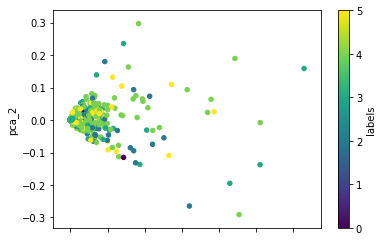

In [302]:
df.plot.scatter(x='pca_1',
                y='pca_2',
                c='labels',
                colormap='viridis')

# Visualize

In [303]:
holdings_pca.shape

(7632, 100)

ValueError: Found input variables with inconsistent numbers of samples: [100, 1845]

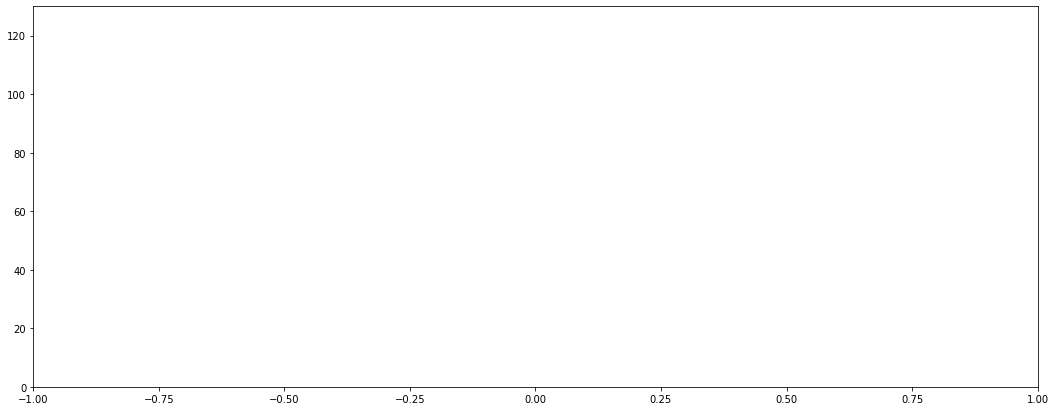

In [281]:
### Based on example code from sklearn ###

X = holdings_pca
n_clusters = [2,3,4,5,6,7,8,9,10]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()